In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
dfTest = pd.read_csv('../testSample.csv')

In [6]:
dfTest[dfTest.set=='test']

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,193831,anonymized_473251.jpg,normal,0,test
1,95716,anonymized_293386.jpg,normal,0,test
2,81979,anonymized_268603.jpg,normal,0,test
3,14583,anonymized_112071.jpg,normal,0,test
4,131181,anonymized_359093.jpg,normal,0,test
...,...,...,...,...,...
1945,226911,anonymized_532403.jpg,precoz,1,test
1946,227202,anonymized_532920.jpg,intermedia,1,test
1947,227204,anonymized_532922.jpg,intermedia,1,test
1948,227261,anonymized_533017.jpg,precoz,1,test


In [10]:
dfTest[(dfTest.binary==0) & (dfTest.set=='test')]

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,193831,anonymized_473251.jpg,normal,0,test
1,95716,anonymized_293386.jpg,normal,0,test
2,81979,anonymized_268603.jpg,normal,0,test
3,14583,anonymized_112071.jpg,normal,0,test
4,131181,anonymized_359093.jpg,normal,0,test
...,...,...,...,...,...
970,200652,anonymized_485899.jpg,normal,0,test
971,62589,anonymized_233180.jpg,normal,0,test
972,36700,anonymized_183225.jpg,normal,0,test
973,35519,anonymized_181087.jpg,normal,0,test


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [9]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.0014454397605732083)

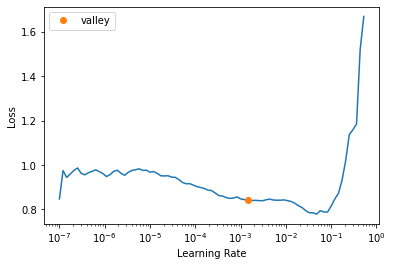

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.688333,0.491113,0.775641,0.757794,0.810256,0.783147,0.857686,00:59


Better model found at epoch 0 with f1_score value: 0.7831474597273853.


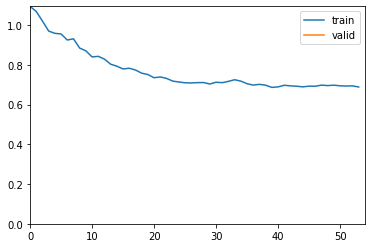

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.472668,0.365251,0.805128,0.881410,0.705128,0.783476,0.889122,01:03
1,0.416829,0.257580,0.825641,0.873529,0.761538,0.813699,0.898951,01:02
2,0.361343,0.250924,0.823077,0.875000,0.753846,0.809917,0.901338,01:02
3,0.322419,0.213363,0.835897,0.876437,0.782051,0.826558,0.910710,01:02
4,0.278601,0.171301,0.842308,0.896142,0.774359,0.830812,0.919162,01:02
5,0.248958,0.187189,0.851282,0.905325,0.784615,0.840659,0.923452,01:02
6,0.223096,0.140260,0.866667,0.890710,0.835897,0.862434,0.932922,01:02
7,0.200930,0.158874,0.847436,0.924765,0.756410,0.832158,0.931499,01:03
8,0.176221,0.127603,0.856410,0.865789,0.843590,0.854545,0.928981,01:03
9,0.153713,0.118708,0.882051,0.902703,0.856410,0.878947,0.937153,01:04


Better model found at epoch 0 with f1_score value: 0.7834757834757834.


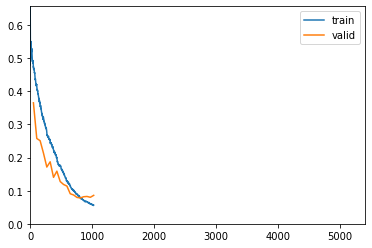

Better model found at epoch 1 with f1_score value: 0.8136986301369862.
Better model found at epoch 3 with f1_score value: 0.8265582655826558.
Better model found at epoch 4 with f1_score value: 0.8308115543328748.
Better model found at epoch 5 with f1_score value: 0.8406593406593407.
Better model found at epoch 6 with f1_score value: 0.8624338624338624.
Better model found at epoch 9 with f1_score value: 0.8789473684210527.
Better model found at epoch 12 with f1_score value: 0.8811748998664887.
Better model found at epoch 13 with f1_score value: 0.888597640891219.
Better model found at epoch 19 with f1_score value: 0.8985507246376813.
No improvement since epoch 14: early stopping


In [11]:
learn.fine_tune(100,base_lr=1e-3)

In [18]:
dfTest = pd.read_csv('../testSample.csv')

In [19]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [20]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [21]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [22]:
learn.dls = dlsTest

In [23]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9527963182117029.


(#6) [0.09094332903623581,0.8907692432403564,0.9027484143763214,0.8758974358974358,0.8891202498698594,0.9527963182117029]

# 384

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet50_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn =  cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('resnet_224')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.00015848931798245758)

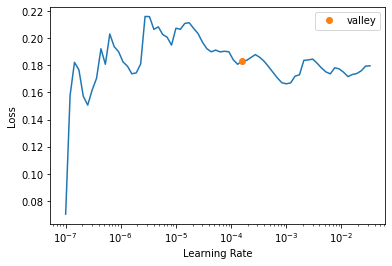

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.110637,0.080937,0.873077,0.877922,0.866667,0.872258,0.943373,01:21


Better model found at epoch 0 with f1_score value: 0.8722580645161291.


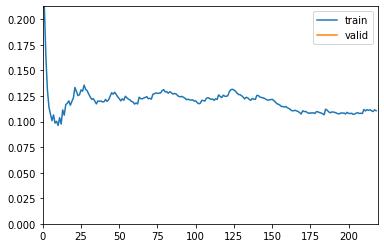

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.088945,0.084897,0.875641,0.942598,0.800000,0.865465,0.956029,01:30
1,0.070038,0.066660,0.900000,0.935754,0.858974,0.895722,0.963330,01:29
2,0.063222,0.066714,0.907692,0.903553,0.912821,0.908163,0.961690,01:30
3,0.070314,0.067748,0.891026,0.920110,0.856410,0.887118,0.961884,01:30
4,0.056038,0.088263,0.884615,0.965839,0.797436,0.873596,0.963892,01:31
5,0.054051,0.086504,0.880769,0.959752,0.794872,0.869565,0.956568,01:30
6,0.052332,0.085324,0.892308,0.952663,0.825641,0.884615,0.959014,01:31


Better model found at epoch 0 with f1_score value: 0.8654646324549238.


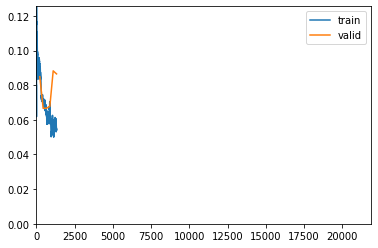

Better model found at epoch 1 with f1_score value: 0.8957219251336898.
Better model found at epoch 2 with f1_score value: 0.9081632653061223.
No improvement since epoch 1: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.960264036817883.


(#6) [0.07035919278860092,0.9020512700080872,0.8927855711422845,0.9138461538461539,0.9031931069437403,0.960264036817883]

# 512

In [18]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnet50_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [21]:
learn = cnn_learner(dls,resnet50,
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [22]:
learn.load('resnet50_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=3.311311274956097e-06)

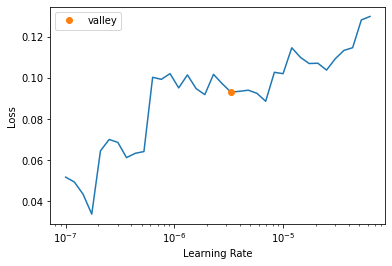

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.118329,0.066617,0.896154,0.889169,0.905128,0.897078,0.961443,02:39


Better model found at epoch 0 with f1_score value: 0.8970775095298602.


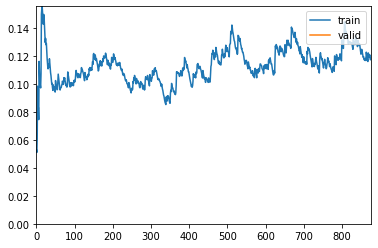

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.130746,0.066716,0.900000,0.882353,0.923077,0.902256,0.963389,03:09
1,0.105158,0.064809,0.901282,0.894207,0.910256,0.902160,0.963340,03:08
2,0.131440,0.064994,0.898718,0.903896,0.892308,0.898065,0.962824,03:08
3,0.137247,0.066714,0.892308,0.896373,0.887179,0.891753,0.961108,03:08
4,0.114841,0.065491,0.898718,0.897698,0.900000,0.898848,0.962817,03:09
5,0.156877,0.065142,0.901282,0.894207,0.910256,0.902160,0.963300,03:09
6,0.121883,0.066374,0.901282,0.915119,0.884615,0.899609,0.962429,03:09


Better model found at epoch 0 with f1_score value: 0.9022556390977443.


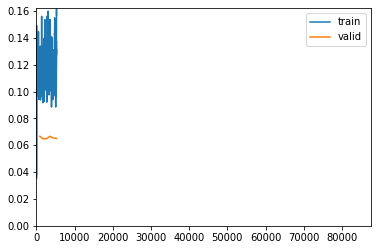

No improvement since epoch 1: early stopping


In [24]:
learn.fine_tune(100,base_lr=1e-7)

In [25]:
dfTest = pd.read_csv('../testSample.csv')

In [26]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [27]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [28]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [29]:
learn.dls = dlsTest

In [30]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9575726495726495.


(#6) [0.07746291905641556,0.8917948603630066,0.8652007648183556,0.9282051282051282,0.8955962394854032,0.9575726495726495]